In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_3056027/477056521.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# path = os.path.join("grad_results/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_0",
#                     "sharing_record.csv")
# df = pd.read_csv(path)
# df.head()

path = "experiment_results/jorge_setting_fedavg_divergence.csv"
df = pd.read_csv(path)
df.head()

,task_id,communication_round,epoch,algo,dataset,use_contrastive,avg_params,avg_params_stderr,avg_params_std
0,4,0,400,modular,fashionmnist,False,1.358460e-09,1.207997e-10,1.366693e-09
1,4,0,400,modular,kmnist,False,1.366869e-09,1.216154e-10,1.375922e-09
2,4,0,400,modular,mnist,False,1.339414e-09,1.189640e-10,1.345924e-09
3,4,0,400,monolithic,fashionmnist,False,1.020571e-02,1.944084e-04,2.199480e-03
4,4,0,400,monolithic,kmnist,False,9.263932e-03,1.684443e-04,1.905730e-03


In [3]:
def get_magma_colors(total_elements):
    start = 0.2
    stop = 0.8
    cm_subsection = np.linspace(start, stop, total_elements)
    return [matplotlib.cm.plasma(x) for x in cm_subsection]

In [4]:
# get unique algo, dataset, and use_contrastive
algo_list = df["algo"].unique()
dataset_list = df["dataset"].unique()
use_contrastive_list = df["use_contrastive"].unique()

algo_list, dataset_list, use_contrastive_list

(array(['modular', 'monolithic'], dtype=object),
 array(['fashionmnist', 'kmnist', 'mnist'], dtype=object),
 array([False]))

In [5]:
len(algo_list) * len(dataset_list) * len(use_contrastive_list)

6

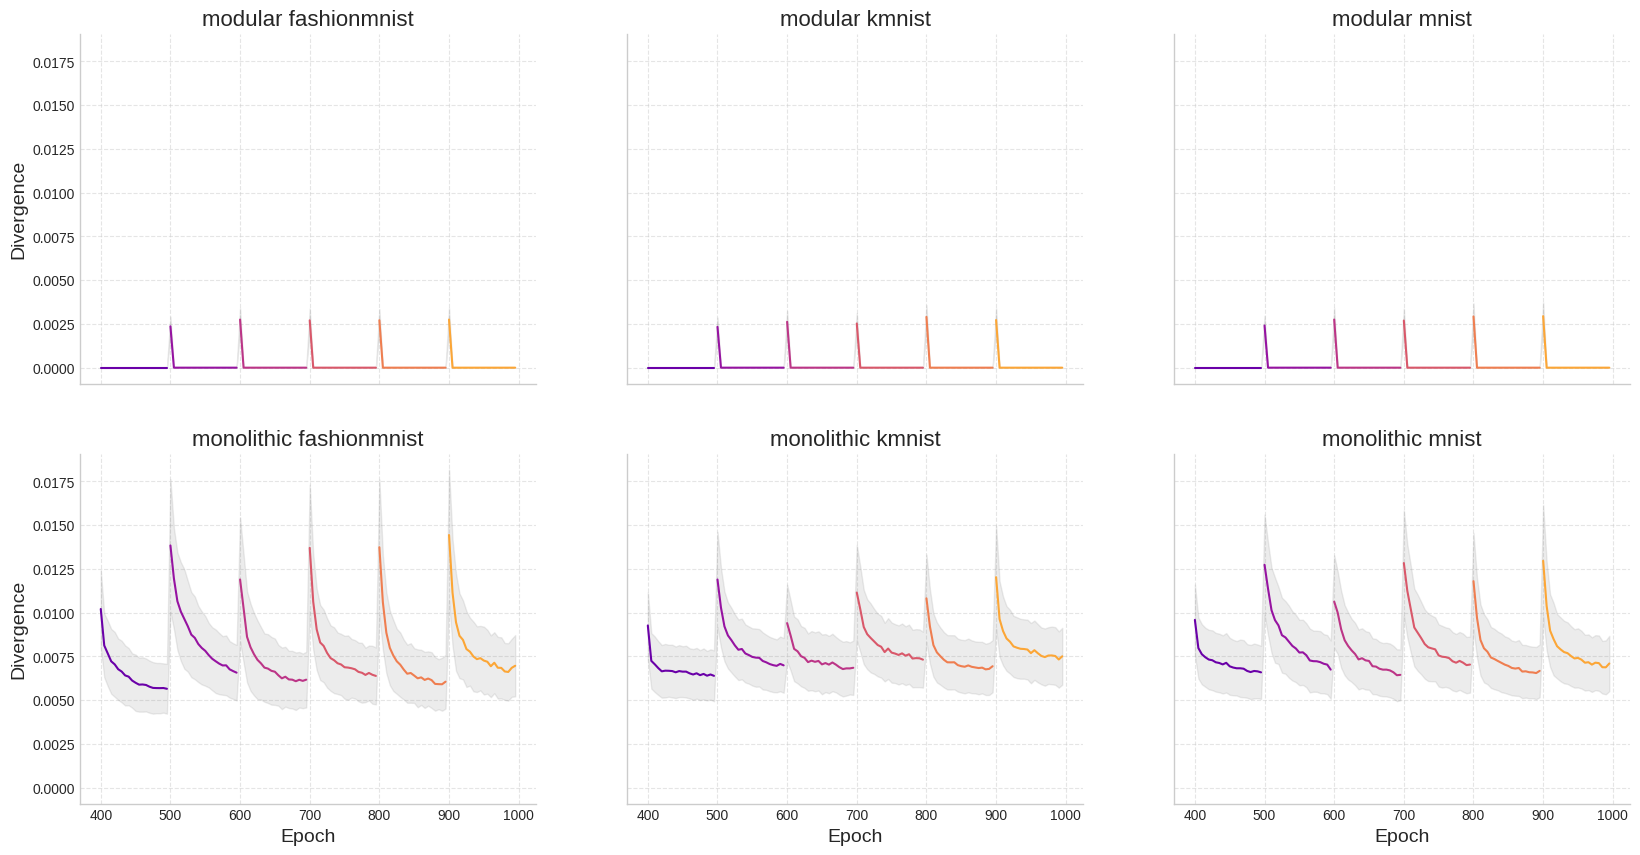

In [6]:

# take one combination of algo, dataset, and use_contrastive,
# and make df_one



# Create a plot with colored and labeled data points
# var = "avg_params_stderr"
var = "avg_params_std"
fig, axs = plt.subplots(figsize=(20, 10), nrows=2, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()
plot_count = 0
for algo in algo_list:
        for dataset in dataset_list:
                for use_contrastive in use_contrastive_list: 
                        ax = axs[plot_count]
                        plot_count +=1
                        df_one = df[(df["algo"] == algo) & (df["dataset"] == dataset) & (df["use_contrastive"] == use_contrastive)]
                        num_colors = len(df_one['task_id'].unique())

                        colors = get_magma_colors(num_colors)

                        for i, (task_id, group) in enumerate(df_one.groupby('task_id')):
                                line = group.plot(x='epoch', y='avg_params', ax=ax,
                                label=i,
                                color=colors[i],
                        )

                        ax.fill_between(df_one['epoch'], df_one['avg_params'] - df_one[var], df_one['avg_params'] + df_one[var], 
                                        alpha=0.15, color='grey')
                        ax.get_legend().remove()
                        ax.set_xlabel("Epoch", fontsize=14)
                        ax.set_ylabel("Divergence", fontsize=14)
                        ax.set_title(f"{algo} {dataset}", fontsize=16)
                        ax.grid(True, which='major', linestyle='--', alpha=0.5)
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)

plt.savefig("Figures/grad/divergence.pdf", bbox_inches='tight')

In [7]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.CRITICAL)

In [8]:
from collections import defaultdict
from shell.utils.record import Record
def l1_distance(module1, module2):
    """
    Compute the L1 distance between two nn.Linear modules, considering both weights and biases.
    """
    weight_diff_avg = torch.mean(torch.abs(module1.weight - module2.weight)).item()
    bias_diff_avg = torch.mean(torch.abs(module1.bias - module2.bias)).item()
    return (weight_diff_avg + bias_diff_avg) / 2

def diff_between(agent, neighbor):
    """
    For each module in agent.net.components, find the closest module in neighbor.net.components based
    on L1 distance. Returns a list of distances where each distance corresponds to the closest module
    in neighbor for each module in agent.
    """
    diffs = defaultdict(lambda: float('inf'))

    # Iterate through each module in the agent
    for i, agent_module in enumerate(agent.net.components):
        # Compare with each module in the neighbor to find the closest one
        for j, neighbor_module in enumerate(neighbor.net.components):
            distance = l1_distance(agent_module, neighbor_module)
            # print(i, j, distance)
            diffs[f'comp.{i}'] = min(diffs[f'comp.{i}'], distance)

    return diffs

In [9]:
def compute_fleet_diffs(fleet):
    # Initialize a dictionary to store the summed distances for each component of each agent
    summed_diffs = defaultdict(lambda: defaultdict(list))
    
    # Initialize a dictionary to store the final averaged results for each agent
    final_diffs = {}
    
    n_agents = len(fleet.agents)
    
    # Calculate differences for each pair of agents
    for i, agent in enumerate(fleet.agents):
        for j, neighbor in enumerate(fleet.agents):
            if i == j:
                continue  # Skip comparing the agent with itself
            diffs = diff_between(agent, neighbor)
            for comp, diff in diffs.items():
                summed_diffs[i][comp].append(diff)
    
    # Calculate mean differences for each component of each agent
    for agent_idx, comps_diffs in summed_diffs.items():
        final_diffs[agent_idx] = {}
        for comp, diffs in comps_diffs.items():
            final_diffs[agent_idx][comp] = np.mean(diffs)
    
    # Calculate `avg_params` for each agent
    for agent_idx, comps_diffs in final_diffs.items():
        avg_params = np.mean(list(comps_diffs.values()))
        final_diffs[agent_idx]['avg_params'] = avg_params
    
    return final_diffs

In [10]:
def record_fleet_div(save_dir, start_task_id, end_task_id,
                     modify_cfg, parallel=False):
    fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=parallel,
                    task_id=start_task_id)
    
    for agent in fleet.agents:
        agent.div_record = Record(os.path.join(agent.save_dir, "div_record.csv"))

    for t in range(start_task_id, end_task_id+1):
        fleet.load_model_from_ckpoint(task_ids=t)
        diffs = compute_fleet_diffs(fleet)
        for agent_idx, diff in diffs.items():
            diff['task_id'] = t
            diff['communication_round'] = 0
            agent = fleet.agents[agent_idx]
            agent.div_record.write(diff)
            agent.div_record.save()


In [11]:
datasets = ["mnist", "kmnist", "fashionmnist"]

experiment_folder = "experiment_results"
experiment_name = "vanilla_jorge_setting_basis_no_sparse"
# experiment_name = "jorge_setting_fedavg"

use_contrastive_opt = False
num_trains_per_class = 64
seeds = [0, 1, 2, 3, 4, 5, 6, 7]

algo = "monolithic"


def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [12]:
# for dataset in datasets:
#     for seed in seeds:
#         save_dir = get_save_dir(experiment_folder, experiment_name,
#                                                 dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
#         record_fleet_div(save_dir, 4, 9, modify_cfg)

In [13]:
import re
from shell.utils.metric import DivergenceMetric
from shell.utils.record import Record
import os
import pandas as pd

result_dir = "experiment_results/jorge_setting_fedavg"

pattern = r".*"

def get_div_df(result_dir):
    concat_df = pd.DataFrame()
    for job_name in os.listdir(result_dir):
        use_contrastive = "contrastive" in job_name
        if use_contrastive:
            continue
        for dataset_name in os.listdir(os.path.join(result_dir, job_name)):
            for algo in os.listdir(os.path.join(result_dir, job_name, dataset_name)):
                if algo == "modular":
                    continue
                for seed in os.listdir(os.path.join(result_dir, job_name, dataset_name, algo)):
                    for agent_id in os.listdir(os.path.join(result_dir, job_name, dataset_name, algo, seed)):
                        if agent_id == "hydra_out" or agent_id == "agent_69420":
                            continue
                        save_dir = os.path.join(
                            result_dir, job_name, dataset_name, algo, seed, agent_id)
                        # if the pattern doesn't match, continue
                        if not re.search(pattern, save_dir):
                            continue
                        df = pd.read_csv(os.path.join(save_dir, "div_record.csv"))
                        df = df[["task_id", "communication_round",
                                "avg_params"]]
                        # add seed and agent_id columns
                        df["seed"] = seed
                        df["agent_id"] = agent_id
                        df['algo'] = algo
                        df['dataset'] = dataset_name
                        df['use_contrastive'] = use_contrastive
                        concat_df = pd.concat([concat_df, df])
    return concat_df

In [14]:
fedavg_concat_df = get_div_df("experiment_results/jorge_setting_fedavg")
mono_concat_df = get_div_df("experiment_results/vanilla_jorge_setting_basis_no_sparse")

FileNotFoundError: [Errno 2] No such file or directory: 'experiment_results/vanilla_jorge_setting_basis_no_sparse/cifar100_monolithic_numtrain_256/cifar100/monolithic/seed_4/agent_1/div_record.csv'

In [ ]:
fedavg_concat_df["algo"] = "fedavg_" + fedavg_concat_df["algo"]

In [15]:
# concat_df = pd.concat([fedavg_concat_df, mono_concat_df])
# concat_df = pd.concat([mono_concat_df])
concat_df = pd.concat([fedavg_concat_df])
concat_df

,task_id,communication_round,avg_params,seed,agent_id,algo,dataset,use_contrastive
0,4,0,0.005013,seed_4,agent_1,monolithic,mnist,False
1,5,0,0.005885,seed_4,agent_1,monolithic,mnist,False
2,6,0,0.005107,seed_4,agent_1,monolithic,mnist,False
3,7,0,0.005606,seed_4,agent_1,monolithic,mnist,False
4,8,0,0.005369,seed_4,agent_1,monolithic,mnist,False
...,...,...,...,...,...,...,...,...
1,5,0,0.004602,seed_0,agent_5,monolithic,kmnist,False
2,6,0,0.004503,seed_0,agent_5,monolithic,kmnist,False
3,7,0,0.005296,seed_0,agent_5,monolithic,kmnist,False
4,8,0,0.004930,seed_0,agent_5,monolithic,kmnist,False


In [16]:
concat_df = concat_df.groupby(
    ["task_id", "communication_round", "algo", "dataset", "use_contrastive"]).agg(
        avg_params=("avg_params", "mean"),
        avg_params_stderr=("avg_params", "sem"),
        avg_params_std=("avg_params", "std")
).reset_index()

In [17]:
concat_df =  concat_df[["task_id", "algo", "dataset", "avg_params", "avg_params_stderr", "avg_params_std"]]
concat_df

,task_id,algo,dataset,avg_params,avg_params_stderr,avg_params_std
0,4,monolithic,fashionmnist,0.004260,0.000084,0.000674
1,4,monolithic,kmnist,0.004820,0.000060,0.000482
2,4,monolithic,mnist,0.004967,0.000066,0.000529
3,5,monolithic,fashionmnist,0.004962,0.000081,0.000648
4,5,monolithic,kmnist,0.005273,0.000055,0.000444
5,5,monolithic,mnist,0.005086,0.000085,0.000679
6,6,monolithic,fashionmnist,0.004667,0.000090,0.000720
7,6,monolithic,kmnist,0.005173,0.000058,0.000463
8,6,monolithic,mnist,0.004867,0.000055,0.000442
9,7,monolithic,fashionmnist,0.004830,0.000089,0.000711


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_datasets(dataframe):
    datasets = dataframe['dataset'].unique()
    algos = dataframe['algo'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(algos)))  # Generate colors for each algorithm

    algo_color_map = {algo: color for algo, color in zip(algos, colors)}  # Map algos to colors

    fig, axs = plt.subplots(1, len(datasets), figsize=(20, 6), sharey=True)
    
    if len(datasets) == 1:  # If there's only one dataset, axs is not an array
        axs = [axs]
    
    for ax, dataset in zip(axs, datasets):
        df_filtered = dataframe[dataframe['dataset'] == dataset]
        task_ids = df_filtered['task_id'].unique()
        
        for algo in algos:
            # Filter by algorithm
            df_algo = df_filtered[df_filtered['algo'] == algo]
            if df_algo.empty:
                continue
            
            # Calculate bar positions
            positions = [i + 0.5 * (np.where(algos == algo)[0][0] - len(algos) / 2) for i in task_ids]
            
            ax.bar(positions, df_algo['avg_params'], yerr=df_algo['avg_params_stderr'], capsize=5,
                   color=algo_color_map[algo], label=algo, width=0.5)
        
        ax.set_title(f'{dataset}')
        ax.set_xlabel('Task ID')
        ax.set_xticks(task_ids)  # Set x-ticks to match the task IDs
        ax.set_ylabel('Average Parameters' if ax is axs[0] else "")
    
    # Add legend outside of the last subplot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), title='Algorithm')

    plt.tight_layout()
    plt.show()

# Assuming `dataframe` is your DataFrame object, call the function with:
# plot_datasets(dataframe)


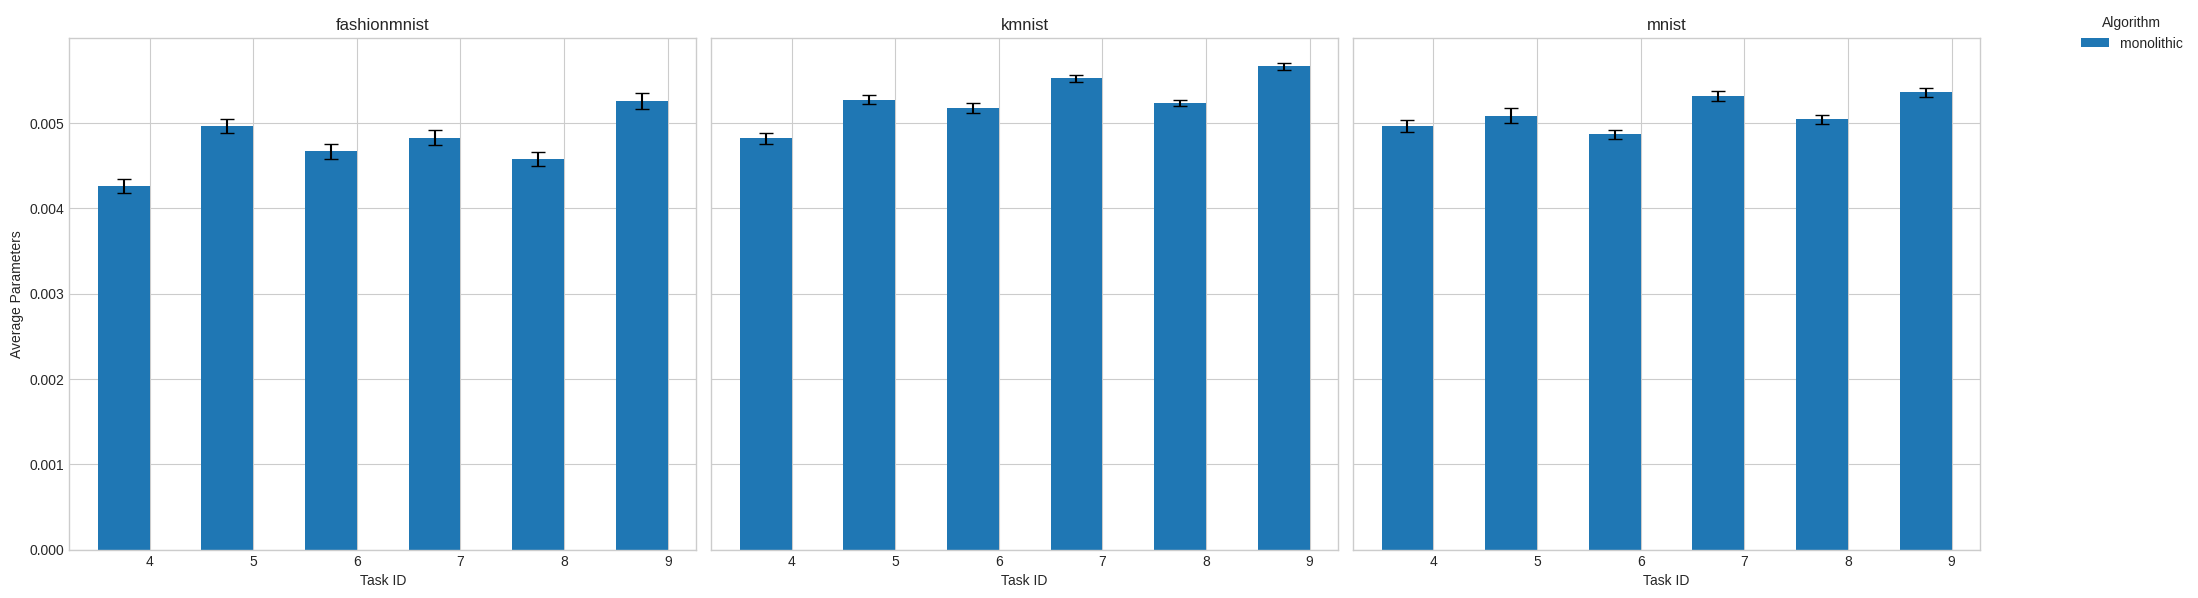

In [19]:
plot_datasets(concat_df)